In [100]:
import warnings
import math

import numpy as np
import pandas as pd

from jre_utils.datapath import (
    factor_data_paths,
    model_ready_data_paths,
    get_price_index_path
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [101]:
dataset_asset_type = "combined"
dataset_key = "transactions"
years_ahead = 3

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "robust"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
metric_sharpe = metric + "_sharpe"
normalized_metric_sharpe = metric_sharpe + "_normalized_yearly"

get_data_path = get_price_index_path


In [102]:
population_path = factor_data_paths["processed"]["population"]["municipality"]
migration_path = factor_data_paths["processed"]["migration"]["municipality"]
taxable_income_path = factor_data_paths["processed"]["taxable_income"]["municipality"]
new_dwellings_path = factor_data_paths["processed"]["new_dwellings"]["municipality"]
lfs_revenue_path = factor_data_paths["processed"]["lfs_revenue_breakdown"]["municipality"]

dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

In [103]:
# concat all asset types horizontally here
# Once creating time series dataset,
# create 3 datasets and concat them vertically
# To do that, loop 3 times with different metrics

In [104]:
id_columns = ["area_code", "area", "year"]

factor_log_normalize_columns = [
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",

    # Log normalizing seems to be good for everything!
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = [
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
)

final_factor_columns = list(set(factor_normalize_columns + factor_log_normalize_columns + factor_columns))

In [105]:
core_log_normalize_columns = ["count", "yearly_price_growth"]
core_normalize_columns = [metric_sharpe]
core_maintain_columns = [metric_sharpe, "metric_sharpe_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

final_core_columns = list(set(core_normalize_columns + core_log_normalize_columns + core_columns))

combined_final_core_columns = [f"{asset_type}_{column}" for column in final_core_columns for asset_type in asset_types]

In [106]:
# combined_final_core_columns

In [107]:
final_columns = id_columns + combined_final_core_columns + final_factor_columns

In [108]:
# Tests

df = pd.read_csv(get_data_path("building"))
df = df.sort_values(by=group_by_columns, ascending=True)
df = df[group_by_columns + [metric]]

# prepare additional factors
df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
df["log_yearly_price_growth"] = np.log(1 + df["yearly_price_growth"])

# prepare main metrics
df[metric_pct_chg] = df.groupby(granularity_columns)[metric].pct_change(
    periods=years_ahead
)

epsilon = math.pow(10, max(-3, -years_ahead))
# epsilon = math.exp(max(-3, -years_ahead))
df[metric_sharpe] = df.groupby(granularity_columns)[
    "log_yearly_price_growth"
].transform(lambda x: x.rolling(years_ahead).mean() / (x.rolling(years_ahead).std() + epsilon))

<Axes: ylabel='Frequency'>

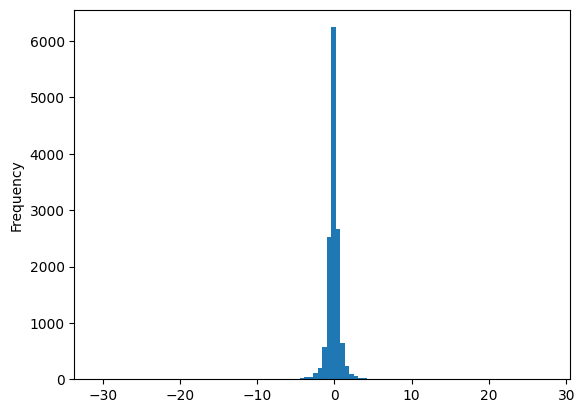

In [109]:
df[metric_sharpe].plot.hist(bins=100)

<Axes: xlabel='robust_price_index_pct_chg', ylabel='robust_price_index_sharpe'>

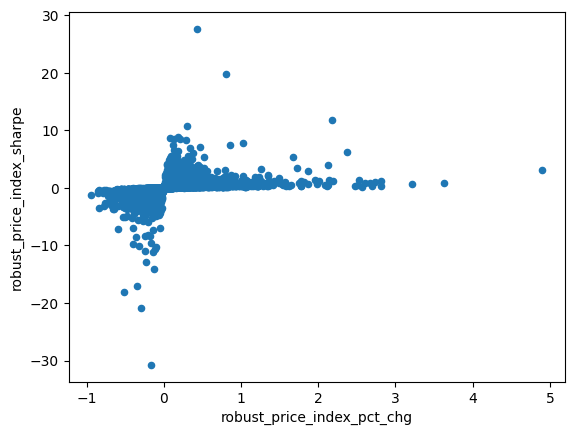

In [110]:
df.plot.scatter(x=metric_pct_chg, y=metric_sharpe)

In [111]:
import math


derived_dfs = {}

for asset_type in asset_types:
    df = pd.read_csv(get_data_path(asset_type))
    df = df.sort_values(by=group_by_columns, ascending=True)
    df = df[group_by_columns + [metric, "count", "robust_weights"]]

    # prepare main metric
    df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
    df["log_yearly_price_growth"] = np.log(1 + df["yearly_price_growth"])

    epsilon = math.pow(10, max(-3, -years_ahead))
    
    df[metric_sharpe] = df.groupby(granularity_columns)[
        "log_yearly_price_growth"
    ].transform(
        lambda x: x.rolling(years_ahead).mean()
        / (x.rolling(years_ahead).std() + epsilon)
    )

    # prepare additional factors
    df["metric_sharpe_is_available"] = df[metric_sharpe].notnull().astype(int)

    for column in core_log_normalize_columns:
        df[f"{column}_log"] = df[column].apply(lambda x: np.log10(1 + x))
        df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
            lambda x: (x - x.mean()) / x.std()
        )

    for column in core_normalize_columns:
        df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
            lambda x: (x - x.mean()) / x.std()
        )


    df = df[group_by_columns + final_core_columns]

    derived_dfs[asset_type] = df.rename(
        columns={column: f"{asset_type}_{column}" for column in final_core_columns}
    )

combined_derived_dfs = (
    derived_dfs["building"]
    .merge(
        derived_dfs["land"],
        on=["year", "area_code", "area"],
        how="outer",
    )
    .merge(
        derived_dfs["condo"],
        on=["year", "area_code", "area"],
        how="outer",
    )
)

In [112]:
df = combined_derived_dfs

population_df = pd.read_csv(population_path)
migration_df = pd.read_csv(migration_path)
taxable_income_df = pd.read_csv(taxable_income_path)
new_dwellings_df = pd.read_csv(new_dwellings_path)
lfs_revenue_df= pd.read_csv(lfs_revenue_path)

df = (
    df.merge(population_df, on=group_by_columns, how="left")
    .merge(migration_df, on=group_by_columns, how="left")
    .merge(taxable_income_df, on=group_by_columns, how="left")
    .merge(new_dwellings_df, on=group_by_columns, how="left")
    .merge(lfs_revenue_df, on=group_by_columns, how="left")
)

In [113]:
df["migrations_is_available"] = df["net_migration_ratio"].notnull().astype(int)
df["taxable_income_is_available"] = df["taxable_income"].notnull().astype(int)
df["total_tax_is_available"] = df["total_tax"].notnull().astype(int)
df["dwellings_is_available"] = df["new_dwellings"].notnull().astype(int)

In [114]:
df = df[final_columns]

In [115]:
df.to_csv(model_ready_data_path, index=False)

In [116]:
df.describe()

,area_code,year,land_yearly_price_growth_log_normalized_yearly,building_yearly_price_growth_log_normalized_yearly,condo_yearly_price_growth_log_normalized_yearly,land_robust_price_index_sharpe,building_robust_price_index_sharpe,condo_robust_price_index_sharpe,land_metric_sharpe_is_available,building_metric_sharpe_is_available,condo_metric_sharpe_is_available,land_count_log_normalized_yearly,building_count_log_normalized_yearly,condo_count_log_normalized_yearly,land_robust_price_index_sharpe_normalized_yearly,building_robust_price_index_sharpe_normalized_yearly,condo_robust_price_index_sharpe_normalized_yearly,land_yearly_price_growth,building_yearly_price_growth,condo_yearly_price_growth,land_count,building_count,condo_count,new_dwellings_ratio_log_normalized_yearly,taxpayer_count_growth_normalized_yearly,existing_dwellings,new_dwellings_ratio,total_tax_is_available,taxable_income_log_normalized_yearly,in_migrations,new_dwellings,taxable_income,taxable_income_per_taxpayer_growth_log_normalized_yearly,taxpayer_count_growth,net_migration_ratio_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,taxpayer_count,taxable_income_per_taxpayer_growth_normalized_yearly,population,taxpayer_count_growth_log_normalized_yearly,net_migration_ratio_log_normalized_yearly,population_log_normalized_yearly,out_migrations,taxable_income_growth,dwellings_is_available,in_migrations_log_normalized_yearly,total_tax_log_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_growth_log_normalized_yearly,taxable_income_per_taxpayer,taxpayer_count_log_normalized_yearly,total_tax_growth,new_dwellings_log_normalized_yearly,total_tax_growth_normalized_yearly,migrations_is_available,taxable_income_is_available,new_dwellings_ratio_normalized_yearly,total_tax_growth_log_normalized_yearly,out_migrations_log_normalized_yearly,total_tax,taxable_income_per_taxpayer_growth,net_migration_ratio,existing_dwellings_log_normalized_yearly
count,19269.000000,19269.000000,1.748400e+04,1.576900e+04,4.423000e+03,15034.000000,13547.000000,3803.000000,18709.000000,16880.000000,4733.000000,1.870900e+04,1.688000e+04,4.733000e+03,1.503400e+04,1.354700e+04,3.803000e+03,17484.000000,15769.000000,4423.000000,18709.000000,16880.000000,4733.000000,11580.000000,18011.000000,1.158000e+04,11580.000000,19269.000000,18011.000000,19269.000000,11580.000000,1.801100e+04,18011.000000,18011.000000,19269.000000,18011.000000,1.801100e+04,18011.000000,1.926900e+04,18011.000000,19269.000000,19269.000000,19269.000000,18011.000000,19269.000000,19269.000000,19207.000000,18011.000000,18011.000000,18011.000000,18011.000000,19189.000000,11580.000000,19189.000000,19269.0,19269.000000,11580.000000,19189.000000,19269.000000,1.920700e+04,18011.000000,19269.000000,11580.000000
mean,21813.182781,2014.824589,2.438376e-18,-2.647244e-18,-2.971974e-17,-0.229551,-0.085537,0.752054,0.803570,0.802547,0.803507,-1.701444e-16,-1.810032e-16,-1.441202e-16,9.452478e-18,-1.521056e-17,7.473497e-18,-0.000733,0.014267,0.032597,87.853279,102.828614,164.578703,-0.078837,0.103493,6.925098e+04,0.013460,0.996782,0.460514,4111.214282,1106.602159,1.546329e+08,-0.014773,0.001648,0.122493,0.215536,4.597966e+04,-0.020401,1.020933e+05,0.106833,0.122747,0.349269,4129.135249,0.003182,0.600965,0.306196,0.594129,0.035069,0.043668,2941.161375,0.464750,0.004762,-0.096868,0.038539,1.0,0.934714,-0.078702,0.040685,0.307891,1.569833e+07,0.001418,-0.002673,-0.092673
std,13413.327988,4.441984,9.995709e-01,9.995242e-01,9.983025e-01,1.103682,1.034965,1.421685,0.397308,0.398089,0.397387,9.995723e-01,9.995259e-01,9.983080e-01,9.995675e-01,9.995200e-01,9.982889e-01,0.238948,0.270295,0.094443,142.895072,225.452285,363.249168,0.950270,0.763519,1.344861e+05,0.006830,0.056634,0.763753,12004.021717,2505.584512,3.877995e+08,0.808420,0.022427,0.690329,1.009514,1.028222e+05,0.796589,2.253104e+05,0.766762,0.680856,0.733855,11530.983407,0.040974,0.489713,0.760144,0.699745,0.784909,0.800446,577.832221,0.746342,0.054952,1.014126,1.10

In [119]:
area_code = 1100
df[df["area_code"] == area_code][["year"] + [f"{asset_type}_{metric_sharpe}" for asset_type in asset_types]]

,year,land_robust_price_index_sharpe,building_robust_price_index_sharpe,condo_robust_price_index_sharpe
5110,2006,NaN,NaN,NaN
5111,2007,NaN,NaN,NaN
5112,2008,NaN,NaN,NaN
5113,2009,NaN,NaN,NaN
5114,2010,-0.630579,-0.808193,NaN
5115,2011,-0.568779,-0.543617,-0.018510
5116,2012,-0.363862,-0.480719,0.538344
5117,2013,0.566053,0.414931,2.153496
5118,2014,-0.292449,-0.074882,3.763646
5119,2015,-0.344331,0.166572,10.582170


In [120]:
# loop

for years_ahead in range(2, 5):
    dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
    model_ready_data_path = model_ready_data_paths[dataset_name]
    
    derived_dfs = {}

    for asset_type in asset_types:
            df = pd.read_csv(get_data_path(asset_type))
            df = df.sort_values(by=group_by_columns, ascending=True)
            df = df[group_by_columns + [metric, "count", "robust_weights"]]

            # prepare main metric
            df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
            df["log_yearly_price_growth"] = np.log(1 + df["yearly_price_growth"])

            epsilon = math.pow(10, max(-3, -years_ahead))
            df[metric_sharpe] = df.groupby(granularity_columns)[
                "log_yearly_price_growth"
            ].transform(
                lambda x: x.rolling(years_ahead).mean()
                / (x.rolling(years_ahead).std() + epsilon)
            )

            # prepare additional factors
            df["metric_sharpe_is_available"] = df[metric_sharpe].notnull().astype(int)

            for column in core_log_normalize_columns:
                df[f"{column}_log"] = df[column].apply(lambda x: np.log10(1 + x))
                df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
                    lambda x: (x - x.mean()) / x.std()
                )

            for column in core_normalize_columns:
                df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
                    lambda x: (x - x.mean()) / x.std()
                )


            df = df[group_by_columns + final_core_columns]

            derived_dfs[asset_type] = df.rename(
                columns={column: f"{asset_type}_{column}" for column in final_core_columns}
            )

    df = (
        derived_dfs["building"].merge(
            derived_dfs["land"],
            on=["year", "area_code", "area"],
            how="outer",
        ).merge(
            derived_dfs["condo"],
            on=["year", "area_code", "area"],
            how="outer",
        )
    )

    population_df = pd.read_csv(population_path)
    migration_df = pd.read_csv(migration_path)
    taxable_income_df = pd.read_csv(taxable_income_path)
    new_dwellings_df = pd.read_csv(new_dwellings_path)
    lfs_revenue_df= pd.read_csv(lfs_revenue_path)

    df = (
        df.merge(population_df, on=group_by_columns, how="left")
        .merge(migration_df, on=group_by_columns, how="left")
        .merge(taxable_income_df, on=group_by_columns, how="left")
        .merge(new_dwellings_df, on=group_by_columns, how="left")
        .merge(lfs_revenue_df, on=group_by_columns, how="left")
    )

    df["migrations_is_available"] = df["net_migration_ratio"].notnull().astype(int)
    df["taxable_income_is_available"] = df["taxable_income"].notnull().astype(int)
    df["total_tax_is_available"] = df["total_tax"].notnull().astype(int)
    df["dwellings_is_available"] = df["new_dwellings"].notnull().astype(int)

    df.to_csv(model_ready_data_path, index=False)
